### Plot Signals

In [ ]:
import pandas as pd
import plotting_util
from math import ceil

df = pd.read_parquet("out/can_data.parquet")
# print(df['lane_position'] != df1['lane_position'])
print(df.columns)
subject_006_sober_rural = df[(df['subject_id'] == '006') & (df['subject_state'] == 'sober') & (df['subject_scenario'] == 'rural')]

times = subject_006_sober_rural['timestamp']

nr_df_cols = len(subject_006_sober_rural.iloc[:, 5:].columns)
nr_rows = ceil(nr_df_cols / 2.0)
nr_cols = 2

fig, axes = plotting_util.create_plot(nr_rows, nr_cols, True, False)
for axs, row in zip(axes, list(range(nr_rows))):
    for ax, col in zip(axs, list(range(nr_cols))):
        plotting_util.set_plot_axis_labels(ax, '', '')
        plotting_util.set_plot_title(ax, subject_006_sober_rural.iloc[:, 4+2*row+col].name)
        ax.plot(times, subject_006_sober_rural.iloc[:, 4+2*row+col])
plotting_util.set_figure_size(fig, 20, 50)

### Plot Segment Positions

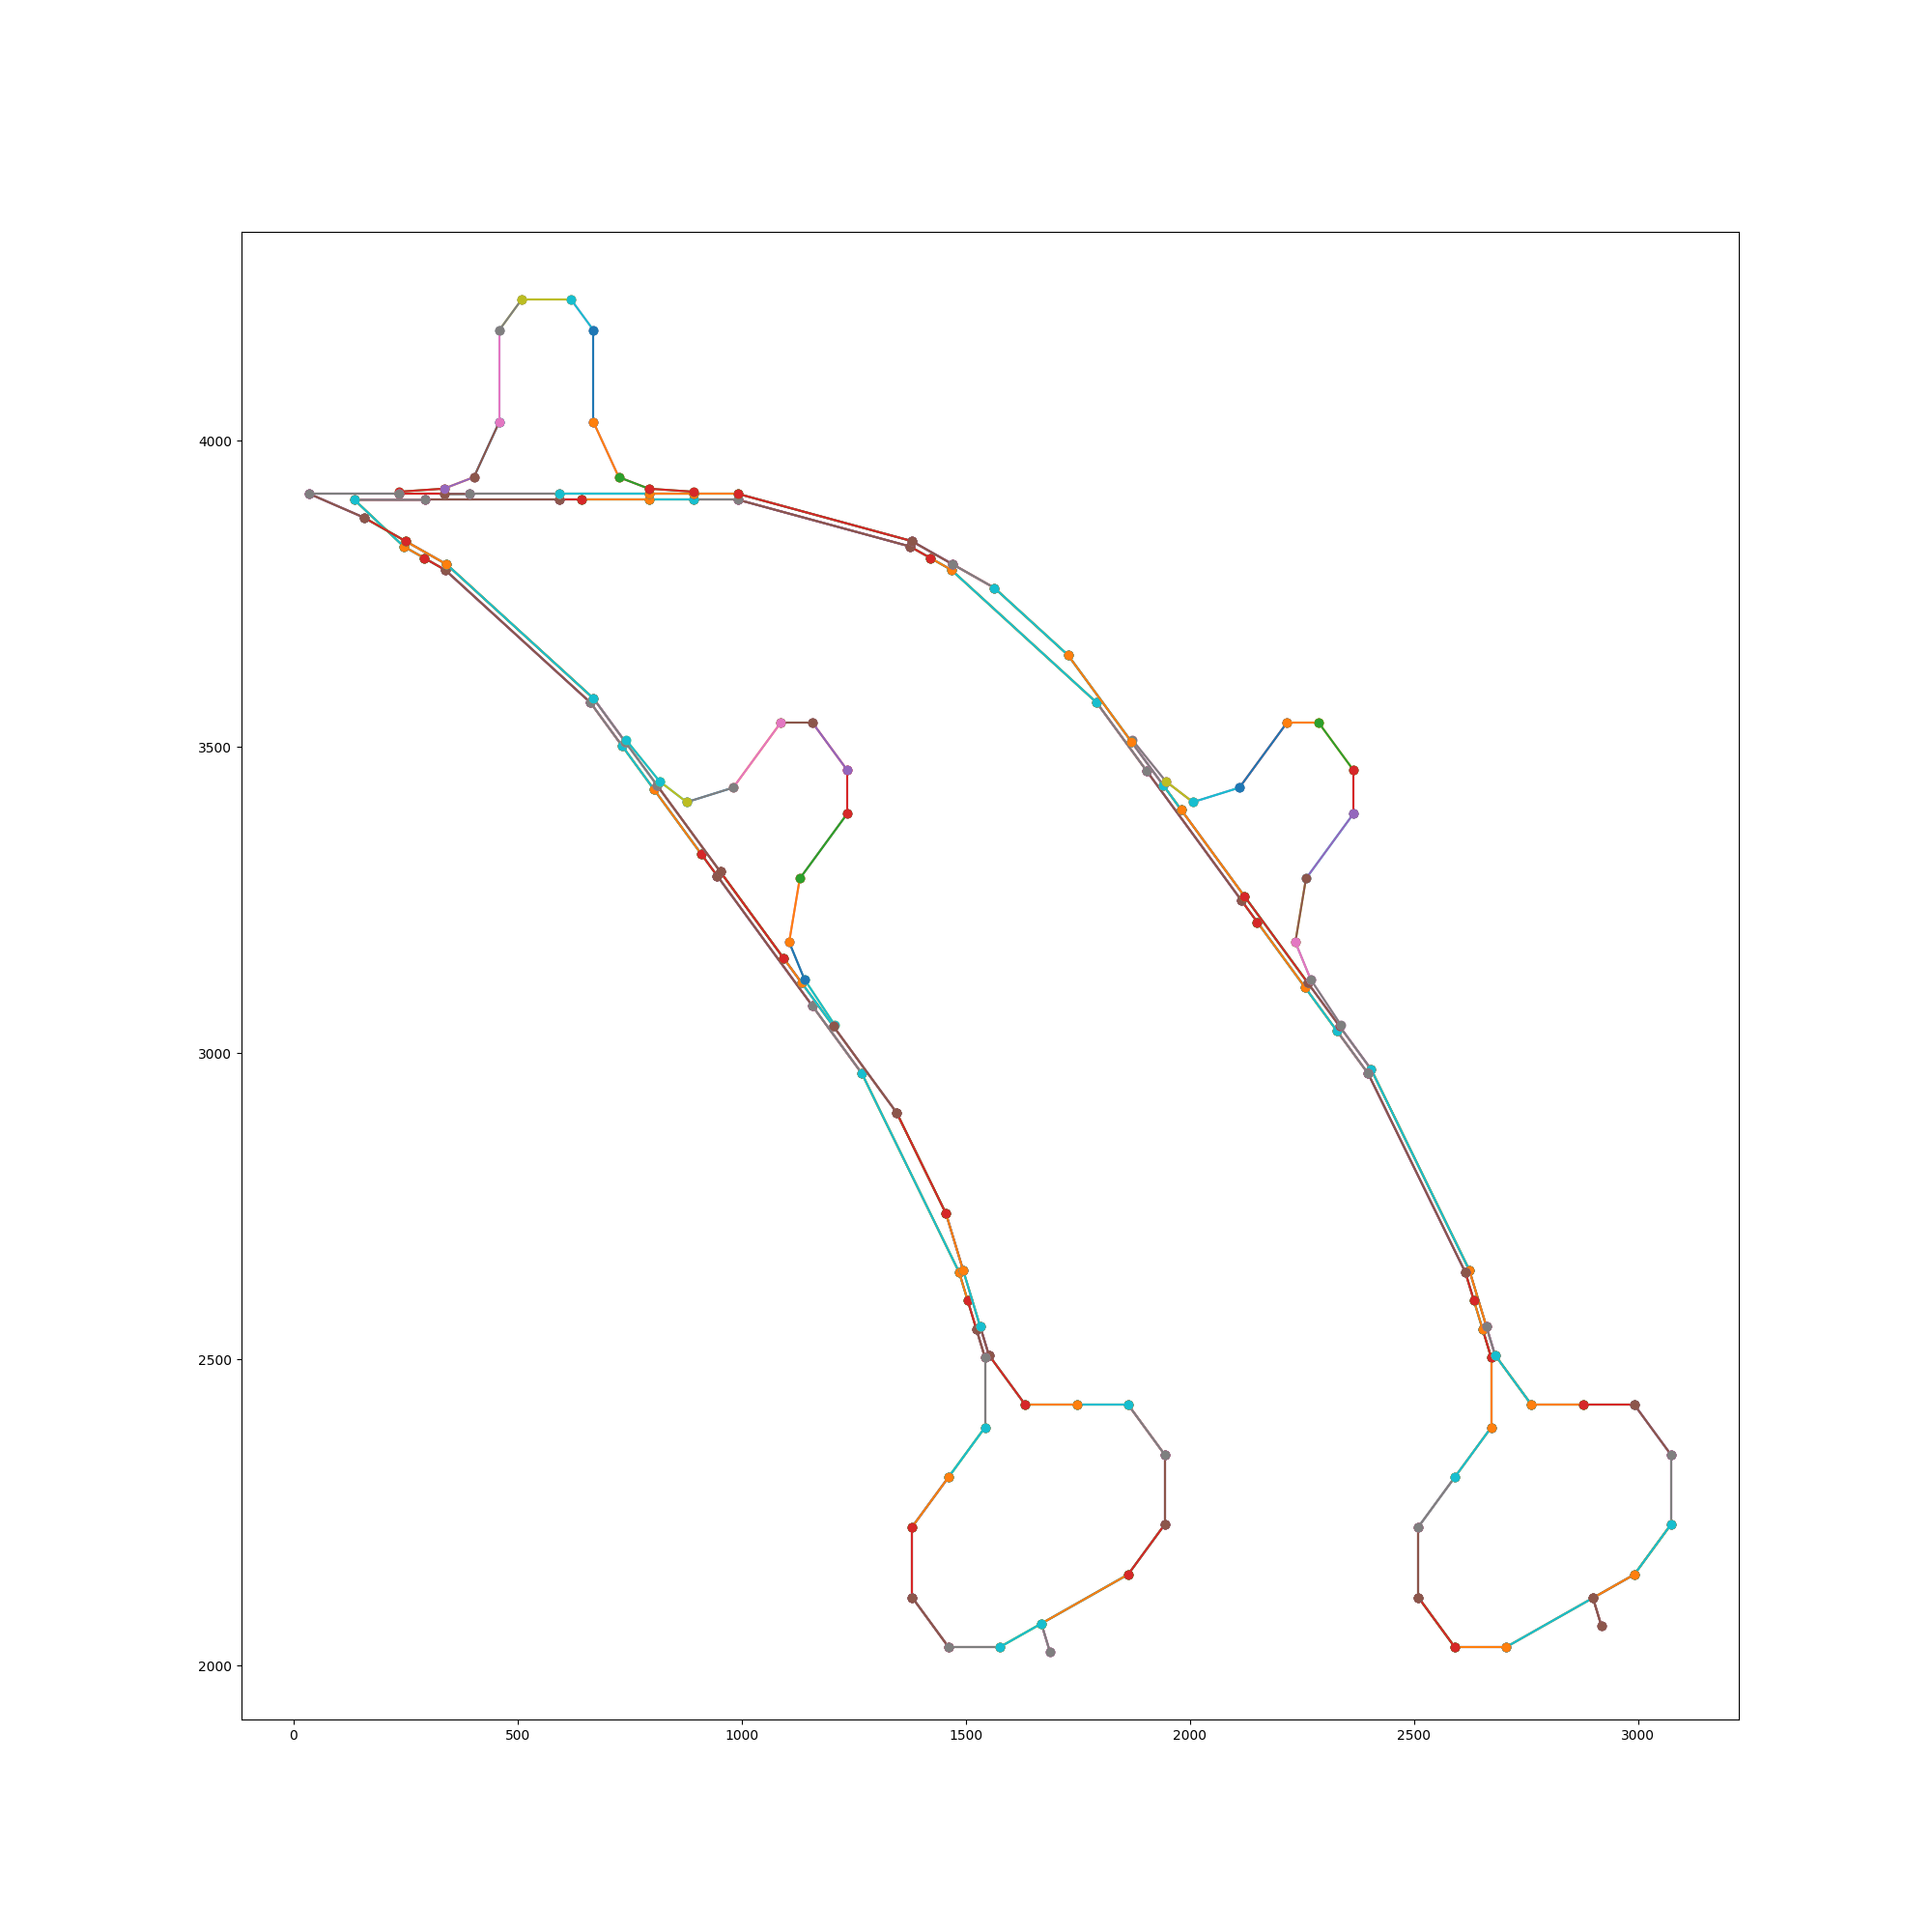

In [3]:
import pandas as pd
import plotting_util
%matplotlib widget
lanes_df = pd.read_csv('out/scenario_information.csv')
lanes_df = lanes_df.loc[lanes_df['scenario'] == 'highway']
fig, ax = plotting_util.create_plot(1,1)
for _, row in lanes_df.iterrows():
    ax.plot([row['StartPos_x_segment'], row['EndPos_x_segment']], [row['StartPos_y_segment'], row['EndPos_y_segment']], 'o-')
plotting_util.set_figure_size(fig, 20, 20)

### Lane Position Validation

In [ ]:
import pandas as pd
import glob
import re
import cv2 as cv
import random
import datetime
import pytz
import os

DATA_FOLDER = '/adar/drive/study'

subject_folders = sorted(glob.glob(DATA_FOLDER + '/*_sober') + glob.glob(DATA_FOLDER + '/*_above') + glob.glob(
            DATA_FOLDER + '/*_below'))
subject_folders = [f for f in subject_folders if 'audio' not in f]

selected_folders = random.sample(subject_folders, 5)
scenarios = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')

subject_re = re.compile('d-([0-9]+)')
timestamp_re = re.compile(r'(\d{4})-(\d{2})-(\d{2})--(\d{2})-(\d{2})-(\d{2}).flv')
for subject in selected_folders:
    subject_id_match = subject_re.search(subject)
    if not subject_id_match:
        continue
    subject_id = subject_id_match.group(1)

    if "drunk" in subject:
        state = "drunk"
    elif "above" in subject:
        state = "above"
    elif "below" in subject:
        state = "below"
    else:
        state = "sober"

    scenario = random.choice(scenarios)
    can_data_for_subject = can_data.loc[(can_data['subject_id'] == subject_id) & (can_data['subject_state'] == state) & (can_data['subject_scenario'] == scenario)]

    print('subject folder: {}, subject_id: {}, state: {}, scenario: {}'.format(subject, subject_id, state, scenario))
    
    for video in glob.glob(subject + '/obs-videos/*.flv'):
        print('video: {}'.format(video.split('/')[-1]))
        match = timestamp_re.search(video.split('/')[-1])
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
            day = int(match.group(3))
            hour = int(match.group(4))
            minute = int(match.group(5))
            second = int(match.group(6))
            video_timestamp = datetime.datetime(year, month, day, hour, minute, second)
            tz = tzinfo=pytz.timezone('Europe/Zurich')
            video_timestamp = tz.localize(video_timestamp)
            can_data_timestamps_ms = (can_data_for_subject['timestamp'] - video_timestamp) / datetime.timedelta(milliseconds=1)
            can_data_segment_id = can_data_for_subject['segment_id']
            can_data_lane_nr = can_data_for_subject['lane_number']
            can_data_lane_pos = can_data_for_subject['lane_position']
            cap = cv.VideoCapture(video)
            sampled_timestamps = sorted(random.sample(list(zip(can_data_timestamps_ms, can_data_segment_id, can_data_lane_nr, can_data_lane_pos)), 10))
            index = 0
            for timestamp_ms, segment_id, lane_nr, lane_pos in sampled_timestamps:
                folder = 'out/' + subject.split('/')[-1]
                if not os.path.exists(folder):
                    os.makedirs(folder)
                is_set = cap.set(cv.CAP_PROP_POS_MSEC, timestamp_ms)
                if is_set:
                    success, frame = cap.read()
                    if success:
                        print('success')
                        img = cv.putText(frame, 'segment id: {}'.format(segment_id), (1300, 1300), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane nr: {}'.format(lane_nr), (1300, 1500), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane pos: {}'.format(lane_pos), (1300, 1700), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        cv.imwrite(folder + '/img{}-{}.png'.format(index, scenario), img)
                        index += 1
                    else:
                        print('could not get frame')
                else:
                    print('could not set video timestamp')